In [1]:
# Importing the libraries needed
import pandas as pd
import numpy as np
import torch
import seaborn as sns
import transformers
import json
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaModel, RobertaTokenizer
import logging
logging.basicConfig(level=logging.ERROR)
from torch import cuda
from lib.dataset_utils import *
from sklearn.metrics import accuracy_score, jaccard_score, f1_score
import matplotlib.pyplot as plt

- Minibatch
- learning rate
- momentum
- regularization
- dropout?
- topologia
- optimizer?

In [2]:
#TODO incapsulare iperparametri
# Defining some key variables that will be used later on in the training
DATASET_NAME = DatasetEnum.GoEmotions
MAX_LEN = 256
MINIBATCH_SIZE = 8
EPOCHS = 1
LEARNING_RATE = 1e-05
FROZEN_LAYERS = 9
loader_params = {'batch_size': MINIBATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }
# Creating the loss function and optimizer
loss_function = torch.nn.BCEWithLogitsLoss()
train_df, val_df, test_df = load_dataset(DATASET_NAME)

In [3]:
train_df[:10]

,text,emotions
0,My favourite food is anything I didn't have to...,27
1,"Now if he does off himself, everyone will thin...",27
2,WHY THE FUCK IS BAYLESS ISOING,2
3,To make her feel threatened,14
4,Dirty Southern Wankers,3
5,OmG pEyToN iSn'T gOoD eNoUgH tO hElP uS iN tHe...,26
6,Yes I heard abt the f bombs! That has to be wh...,15
7,We need more boards and to create a bit more s...,"8,20"
8,Damn youtube and outrage drama is super lucrat...,0
9,It might be linked to the trust factor of your...,27


In [4]:
#TODO cross validation su topologia
class RobertaClass(torch.nn.Module):
    def __init__(self, n_classes, frozen_layers=-1):
        super(RobertaClass, self).__init__()
        self.l1 = RobertaModel.from_pretrained("roberta-base")
        if frozen_layers != -1:
            for param in self.l1.embeddings.parameters():
                param.requires_grad = False
            for i in range(frozen_layers):
                for param in self.l1.encoder.layer[i].parameters():
                    param.requires_grad = False
        self.pre_classifier = torch.nn.Linear(768, 768)#TODO add_module?
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(768, n_classes)

    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output
    
    def get_out_dim(self):
        return self.classifier.out_features

In [5]:
def create_model_params(optimizer=torch.optim.Adam,
                        tokenizer=RobertaTokenizer.from_pretrained('roberta-base', truncation=True, do_lower_case=True),
                        tokenizer_max_len=256,
                        loader_params={'batch_size': 8, 'shuffle': True, 'num_workers': 0},
                        loss_function=torch.nn.BCEWithLogitsLoss(),
                        epochs=1,
                        learning_rate=1e-05,
                        val_patience=1):
    return {
        'optimizer': optimizer,
        'tokenizer': tokenizer,
        'tokenizer_max_len': tokenizer_max_len,
        'loader_params': loader_params,
        'loss_function': loss_function,
        'epochs': epochs,
        'learning_rate': learning_rate,
        'val_patience': val_patience
    }

class SimpleModelInterface:
    def __init__(self, 
                 model: torch.nn.Module, 
                 scores={},
                 model_params_dict=create_model_params()):
        self.model = model
        self.params = model_params_dict
        self.optimizer = model_params_dict['optimizer'](params=model.parameters(), lr=model_params_dict['learning_rate'])
        self.scores = scores
        self.train_scores = {name: [] for name in scores.keys()}
        self.train_loss = []
        self.val_scores = {name: [] for name in scores.keys()}
        self.val_loss = []
        self.device = 'cuda' if cuda.is_available() else 'cpu'
        model.to(self.device)

    def _train(self, training_loader, validation_loader=None):
        self.model.train()
        #TODO usare confusion matrix?
        cur_patience = self.params['val_patience']
        best_val_loss = np.inf
        for _ in range(self.params['epochs']):
            tr_loss = 0
            predictions_acc = []
            targets_acc = []
            for _,data in tqdm(enumerate(training_loader, 0)):
                ids = data['ids'].to(self.device, dtype = torch.long)
                mask = data['mask'].to(self.device, dtype = torch.long)
                token_type_ids = data['token_type_ids'].to(self.device, dtype = torch.long)
                targets = data['targets'].to(self.device, dtype = torch.float)

                outputs = self.model(ids, mask, token_type_ids)
                loss = loss_function(outputs, targets)
                tr_loss += loss.item()
                # append predictions and targets
                predictions_acc.extend(torch.sigmoid(outputs).detach().cpu().numpy())
                targets_acc.extend(targets.detach().cpu().numpy())

                # backward pass
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

            # create numpy arrays
            predictions_acc = np.array(predictions_acc)
            targets_acc = np.array(targets_acc)
            # calculate training scores
            epoch_loss = tr_loss/len(training_loader)
            self.train_loss.append(epoch_loss)
            for name, score in self.scores.items():
                self.train_scores[name].append(score(targets_acc, predictions_acc))

            # calculate validation scores
            if validation_loader is not None:
                val_scores = self.evaluate(validation_loader)
                for name, score in val_scores.items():
                    self.val_scores[name].append(score)
                self.val_loss.append(val_scores['loss'])
                if val_scores['loss'] < best_val_loss:
                    best_val_loss = val_scores['loss']
                    cur_patience = self.params['val_patience']
                else:
                    cur_patience -= 1
                if cur_patience == 0:
                    break

    def fit(self, training_df, validation_df=None):
        training_loader = create_data_loader_from_dataframe(training_df, self.params['tokenizer'], self.params['tokenizer_max_len'], **self.params['loader_params'])
        validation_loader = None
        if validation_df is not None:
            validation_loader = create_data_loader_from_dataframe(validation_df, self.params['tokenizer'], self.params['tokenizer_max_len'], **self.params['loader_params'])
        self._train(training_loader, validation_loader)

    def _predict(self, data_loader, compute_scores=False):
        self.model.eval()
        pred_loss=0
        # initialize target and prediction matrices
        predictions_acc = []
        targets_acc = []
        with torch.no_grad():
            for _, data in tqdm(enumerate(data_loader, 0)):
                ids = data['ids'].to(self.device, dtype = torch.long)
                mask = data['mask'].to(self.device, dtype = torch.long)
                token_type_ids = data['token_type_ids'].to(self.device, dtype=torch.long)
                targets = data['targets'].to(self.device, dtype = torch.float)
                outputs = self.model(ids, mask, token_type_ids).squeeze()
                if compute_scores:
                    # accumulate loss
                    loss = loss_function(outputs, targets)
                    pred_loss += loss.item()
                # append predictions and targets
                predictions_acc.extend(torch.sigmoid(outputs).detach().cpu().numpy())
                targets_acc.extend(targets.detach().cpu().numpy())
        return np.array(targets_acc), np.array(predictions_acc), pred_loss

    def predict(self, testing_df):
        testing_loader = create_data_loader_from_dataframe(testing_df, self.params['tokenizer'], self.params['tokenizer_max_len'], **self.params['loader_params'])
        target, out, _ = self._predict(testing_loader, compute_scores=False)
        return out, target

    def evaluate(self, testing_df):
        testing_loader = create_data_loader_from_dataframe(testing_df, self.params['tokenizer'], self.params['tokenizer_max_len'], **self.params['loader_params'])
        targets_acc, predictions_acc, pred_loss = self._predict(testing_loader, compute_scores=True)
        # calculate scores
        scores = {name: score(targets_acc, predictions_acc) for name, score in self.scores.items()}
        scores['loss'] = pred_loss/len(testing_loader)
        return scores

    def get_train_scores(self):
        return self.train_scores
    
    def get_train_loss(self):
        return self.train_loss

    def get_val_scores(self):
        return self.val_scores
    
    def get_val_loss(self):
        return self.val_loss
    
    def save_model(self, model_path, vocabulary_path):
        torch.save(self.model, model_path)
        self.tokenizer.save_vocabulary(vocabulary_path)

In [6]:
THRESHOLD = 0.5
def accuracy(y_true, y_pred):
    return accuracy_score(y_true, y_pred > THRESHOLD)

def jaccard(y_true, y_pred):
    return jaccard_score(y_true, y_pred > THRESHOLD, average='macro')#TODO macro?

def f1(y_true, y_pred):
    return f1_score(y_true, y_pred > THRESHOLD, average='macro')

In [7]:
#FIXME nclasses
model = SimpleModelInterface(RobertaClass(28), {'accuracy': accuracy, 'jaccard': jaccard, 'f1': f1}, create_model_params())

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
model.fit(train_df[:1000])

125it [00:52,  2.37it/s]


In [9]:
#FIXME jaccard ed f1 non funzionano correttamente
scores = model.evaluate(test_df[:1000])
scores

0it [00:00, ?it/s]

125it [00:16,  7.55it/s]


{'accuracy': 0.0, 'jaccard': 0.0, 'f1': 0.0, 'loss': 0.22491894996166228}

In [10]:
def tune_sigmoid_threshold(y_true, y_pred, plot=False):
    thresholds = np.arange(0, 1, 0.01)
    scores = [f1_score(y_true, y_pred > t, average='macro') for t in thresholds]
    best_threshold = thresholds[np.argmax(scores)]
    if plot:
        plt.plot(thresholds, scores)
        plt.xlabel('Threshold')
        plt.ylabel('F1 Score')
        plt.title('F1 Score over sigmoid threshold')
        plt.show()
        print(f'Best threshold: {best_threshold}')
    return best_threshold

In [11]:
out, target = model.predict(test_df[:1000])

0it [00:00, ?it/s]

125it [00:16,  7.63it/s]


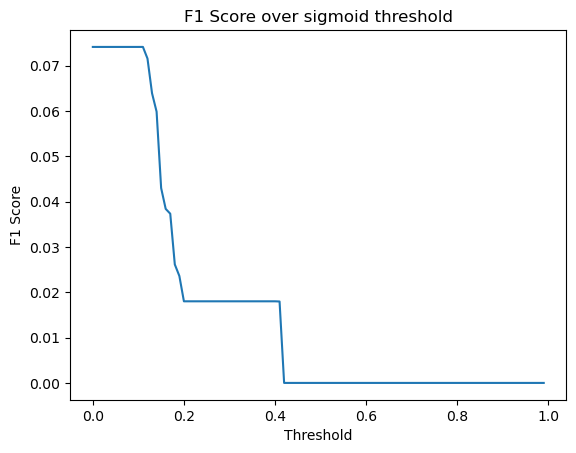

Best threshold: 0.11


0.11

In [20]:
tune_sigmoid_threshold(target, out, plot=True)